## Predicting Car Prices

### Introduction

In this project we'll predict a car's market price using its attributes. The data set we will be working with is provided by [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, and more. You can download the data set directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data).

Let's start with importing libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

%matplotlib inline

Due to the original data set hasn't row with column names we'll set it manualy. We'll takes names from the data set [page](https://archive.ics.uci.edu/ml/datasets/automobile)

In [2]:
columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
          'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
          'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
          'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
          'compresion-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

cars = pd.read_csv('imports-85.data', names=columns)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compresion-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Also let's check `NaN` values and their types.

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

## Preparing the data

There are a lot of columns with the numeric data. But some of them are of the wrong type. Like `bore` which is cylinder diameter is stored like `object`. We should fix it.

Also there are two columns that represent numeric values using words instead of numbers. I mean `num-of-doors` and `num-of-cylinders`.

And finally there is `?` instead of `NaN` at least in the `normalized-losses` column. Probably it isn't the only one.

### Question signs

Let's replace all `?` with `NaN` values to prevent misinterpretation.

In [4]:
cars.replace({'?': np.nan}, inplace=True)
cars.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

Now we clearly see all columns having missing values.

### Cylinders and doors

Now we transform values in the `num-of-doors` and `num-of-cylinders` columns into numbers. Let's check what values do they have for a start.

In [5]:
print(cars['num-of-doors'].unique(), cars['num-of-cylinders'].unique())

['two' 'four' nan] ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']


Using these values let's write functions which we'll apply to the appropriate columns. 

In [6]:
def word_to_num(value):
    #Transorm number word to the actual int numbers
        
    #Create dict with all possible numbers
    help_dict = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
    }
    
    #Check for None value
    if pd.isna(value):
        return np.nan
    else:
        return help_dict[value]
    

cars['num-of-doors'] = cars['num-of-doors'].apply(word_to_num)
cars['num-of-cylinders'] = cars['num-of-cylinders'].apply(word_to_num)

print(cars['num-of-doors'].unique(), cars['num-of-cylinders'].unique())

[ 2.  4. nan] [ 4  6  5  3 12  2  8]


### Converting to numeric

According to the data set description we'll choose all columns that supposed to be numeric but still aren't and covert them.

In [7]:
num_cols = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']

cars[num_cols] = cars[num_cols].astype('float')

### Dealing with missing values

We usually can't have any missing values if we want to use them for predictive modeling so let's male something with them. Let's find all rows and columns with `NaN` values.

In [8]:
cars.loc[cars.isna().any(axis=1), cars.isna().any(axis=0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 193
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  5 non-null      float64
 1   num-of-doors       44 non-null     float64
 2   bore               42 non-null     float64
 3   stroke             42 non-null     float64
 4   horsepower         44 non-null     float64
 5   peak-rpm           44 non-null     float64
 6   price              42 non-null     float64
dtypes: float64(7)
memory usage: 2.9 KB


We have few ways to deal with missing values. We'll make the following :
* `normalized-losses`, `bore`, `stroke`, `horsepower` and `peak-rpm` fill with mean
* `num-of-doors` fill with mode
* drop whole rows with `price` missing

In [9]:
fill_with_mean = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm']

cars[fill_with_mean] = cars[fill_with_mean].fillna(cars[fill_with_mean].mean())

cars['num-of-doors'] = cars['num-of-doors'].fillna(cars['num-of-doors'].mode().iloc[0])

cars.dropna(subset=['price'], inplace=True)

cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   normalized-losses  201 non-null    float64
 2   make               201 non-null    object 
 3   fuel-type          201 non-null    object 
 4   aspiration         201 non-null    object 
 5   num-of-doors       201 non-null    float64
 6   body-style         201 non-null    object 
 7   drive-wheels       201 non-null    object 
 8   engine-location    201 non-null    object 
 9   wheel-base         201 non-null    float64
 10  length             201 non-null    float64
 11  width              201 non-null    float64
 12  height             201 non-null    float64
 13  curb-weight        201 non-null    int64  
 14  engine-type        201 non-null    object 
 15  num-of-cylinders   201 non-null    int64  
 16  engine-size        201 non

We've taken care of all missing values so far.

### Engine size

`Bore`, `stroke` and `num-of-cylinders` can be used to calculate [engine displacement](https://en.wikipedia.org/wiki/Engine_displacement) with the folowing formula:
![Image](https://wikimedia.org/api/rest_v1/media/math/render/svg/dda5493171292ec172a087a2ee6cb24fbe120ad4)

The result obtained by this should be equal `engine-size` values. Let's check it.

In [10]:
cars['engine-displacement'] = (np.pi * cars['stroke'] * cars['num-of-cylinders'] * (
                                    0.5 * cars['bore']) ** 2).apply(round)

cars[['engine-size', 'engine-displacement']].head(10)

,engine-size,engine-displacement
0,130,101
1,130,101
2,152,117
3,109,109
4,136,136
5,136,136
6,136,136
7,136,136
8,131,131
10,108,108


As we can see from to 10 rows some values are extremely different. There are probably more of then so we'll build a plot.

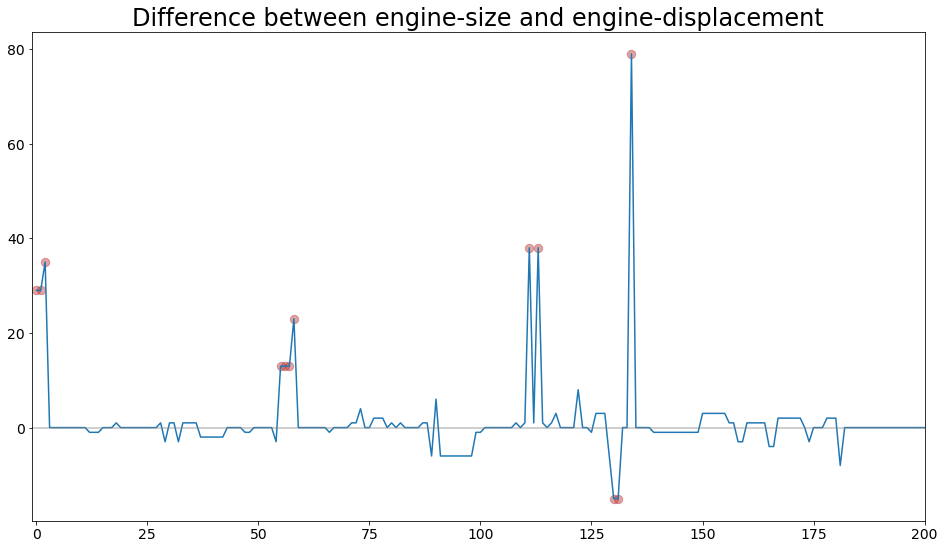

In [11]:
engine_diff = cars['engine-size'] - cars['engine-displacement']

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(engine_diff)

#Zero line
plt.axhline(y=0, 
           xmin=-1, 
           color='gray',
           alpha=0.5
           )

#Outliners plot
ax.scatter(x=engine_diff[np.abs(engine_diff) >= 10].index,
           y=engine_diff[np.abs(engine_diff) >= 10],
           s=70,
           color='firebrick',
           alpha=0.4
          )
        
#Decorations
ax.set_title('Difference between engine-size and engine-displacement', fontsize=24)
ax.set_xlim(-1, 200)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

There are a bunch of outliners. We can't say which one parameter is more accurate for now so we keep them both.

So data set for futher predictions will look like this.

In [12]:
model_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height',
                 'curb-weight', 'compresion-ratio', 'horsepower',
                 'peak-rpm', 'city-mpg', 'highway-mpg',
                 'engine-displacement', 'engine-size', 'price']

cars_model = cars[model_cols]

cars_model.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,compresion-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,engine-displacement,engine-size,price
0,122.0,88.6,168.8,64.1,48.8,2548,9.0,111.0,5000.0,21,27,101,130,13495.0
1,122.0,88.6,168.8,64.1,48.8,2548,9.0,111.0,5000.0,21,27,101,130,16500.0
2,122.0,94.5,171.2,65.5,52.4,2823,9.0,154.0,5000.0,19,26,117,152,16500.0
3,164.0,99.8,176.6,66.2,54.3,2337,10.0,102.0,5500.0,24,30,109,109,13950.0
4,164.0,99.4,176.6,66.4,54.3,2824,8.0,115.0,5500.0,18,22,136,136,17450.0


And finally we'll normalize all values(except prices) in the model data set with the following formula:

![Image](https://miro.medium.com/max/860/1*eO8b-xIGhnLgsQol3O6ksw.png)

In [13]:
prices = cars_model['price']

cars_model = (cars_model - cars_model.min())\
            / (cars_model.max() - cars_model.min())

cars_model['price'] = prices

cars_model.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,compresion-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,engine-displacement,engine-size,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.1250,0.294393,0.346939,0.222222,0.289474,0.207746,0.260377,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.1250,0.294393,0.346939,0.222222,0.289474,0.207746,0.260377,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.1250,0.495327,0.346939,0.166667,0.263158,0.264085,0.343396,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.1875,0.252336,0.551020,0.305556,0.368421,0.235915,0.181132,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.0625,0.313084,0.551020,0.138889,0.157895,0.330986,0.283019,17450.0


## Models

### Univariate k-nearest neighbors model

We'll create a simple function that will: 
* split the data set into a training and test set.
* fit the model and make predictions.
* return the RMSE.

Let's start.

In [14]:
def knn_train_test(train_col, target_col, df):
    '''
    train_col - column to train
    target_col - column to predict
    df - data set
    '''
    
    #Shuffling index
    np.random.seed(1)
    rand_df = df.reindex(np.random.permutation(df.index))
    
    #Splitting data set
    train_qty = int(df.shape[0] * 0.75) #Rows qty for training part
    
    train_df = rand_df.iloc[0:train_qty]
    test_df = rand_df.iloc[train_qty:]
    
    #Instantiating model
    knn = KNeighborsRegressor()
    knn.fit(train_df[[train_col]], train_df[[target_col]])
    predictions = knn.predict(test_df[[train_col]])
    
    #Calculating RMSE
    rmse = mean_squared_error(test_df[target_col], predictions, squared=False)
    
    return rmse

Now we'll use `knn_train_test` function to train and test univariate models using all possible training columns in the model data set. Then compare RMSEs.

In [15]:
train_cols = model_cols[:-1] #All columns except price

col_k_dict = {}

for column in train_cols:
    rmse = knn_train_test(column, 'price', cars_model)
    col_k_dict[column] = rmse
    
col_k_dict_sorted = {key: value for key, value in sorted(col_k_dict.items(), key=lambda item: item[1])}
col_k_dict_sorted

{'engine-displacement': 2729.231163734219,
 'engine-size': 3051.4342223507515,
 'city-mpg': 3684.803553760217,
 'width': 3917.2276702270137,
 'curb-weight': 4011.4500359082417,
 'wheel-base': 4161.947971897813,
 'highway-mpg': 4323.5025303792845,
 'horsepower': 4756.983755346181,
 'length': 5416.294063685402,
 'compresion-ratio': 5958.572328216569,
 'normalized-losses': 6231.311123986794,
 'peak-rpm': 6326.47174389284,
 'height': 6666.667677627373}

In [16]:
cars_model.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,compresion-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,engine-displacement,engine-size,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.1250,0.294393,0.346939,0.222222,0.289474,0.207746,0.260377,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.1250,0.294393,0.346939,0.222222,0.289474,0.207746,0.260377,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.1250,0.495327,0.346939,0.166667,0.263158,0.264085,0.343396,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.1875,0.252336,0.551020,0.305556,0.368421,0.235915,0.181132,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.0625,0.313084,0.551020,0.138889,0.157895,0.330986,0.283019,17450.0


`engine-displacement` showed better accuracy so we'll drop `engine-size` column.

In [17]:
cars_model.drop('engine-size', axis=1, inplace=True)

train_cols.remove('engine-size')
model_cols.remove('engine-size')
col_k_dict_sorted.pop('engine-size')

3051.4342223507515

### Single column hyperparameter variation

We'll update our `knn_train_test` function to variate k values through 1, 3, 5, 7, and 9.

In [18]:
def knn_train_test_hp(train_col, target_col, df):
    '''
    train_col - column to train
    target_col - column to predict
    df - data set
    '''
    
    #Shuffling index
    np.random.seed(1)
    rand_df = df.reindex(np.random.permutation(df.index))
    
    #Splitting data set
    train_qty = int(df.shape[0] * 0.75) #Rows qty for training part
    
    train_df = rand_df.iloc[0:train_qty]
    test_df = rand_df.iloc[train_qty:]
    
    hyperparameters = [1, 3, 5, 7, 9] #hp values
    
    rmses_dict = {} # dict for RMSE from each hp
    
    #Instantiating model for each hp
    for hp in hyperparameters:
        knn = KNeighborsRegressor(hp)
        knn.fit(train_df[[train_col]], train_df[[target_col]])
        predictions = knn.predict(test_df[[train_col]])
    
        #Calculating RMSE
        rmse = mean_squared_error(test_df[target_col], predictions, squared=False)
        rmses_dict[hp] = rmse
        
    return rmses_dict

Now we'll use `knn_train_test_hp` function on the same training columns in the model data set.

In [19]:
col_diff_k_dict = {}

for column in train_cols:
    rmse = knn_train_test_hp(column, 'price', cars_model)
    col_diff_k_dict[column] = rmse
    
col_diff_k_dict

{'normalized-losses': {1: 6499.876425672999,
  3: 6373.107123484384,
  5: 6231.311123986794,
  7: 6434.331952881507,
  9: 6534.518371010953},
 'wheel-base': {1: 2740.62572288541,
  3: 3417.1446705321687,
  5: 4161.947971897813,
  7: 4572.080496976003,
  9: 4488.496411259577},
 'length': {1: 5297.150036557764,
  3: 5507.625440160827,
  5: 5416.294063685402,
  7: 5030.583828449936,
  9: 4407.827047652169},
 'width': {1: 2791.733012966368,
  3: 4083.105499312811,
  5: 3917.2276702270137,
  7: 3722.033525295731,
  9: 3665.167444110463},
 'height': {1: 8302.179086735921,
  3: 7159.369749588925,
  5: 6666.667677627373,
  7: 6570.390279532118,
  9: 6484.278955313533},
 'curb-weight': {1: 3906.6625644092765,
  3: 4156.281651639599,
  5: 4011.4500359082417,
  7: 3811.5247071791855,
  9: 3914.8184777366964},
 'compresion-ratio': {1: 6357.71976018286,
  3: 5732.933869082801,
  5: 5958.572328216569,
  7: 5674.840084089771,
  9: 6218.363072593153},
 'horsepower': {1: 3554.321250115078,
  3: 4351.00

A lot of values! It's to difficult to analyse them so we'll build a plot.

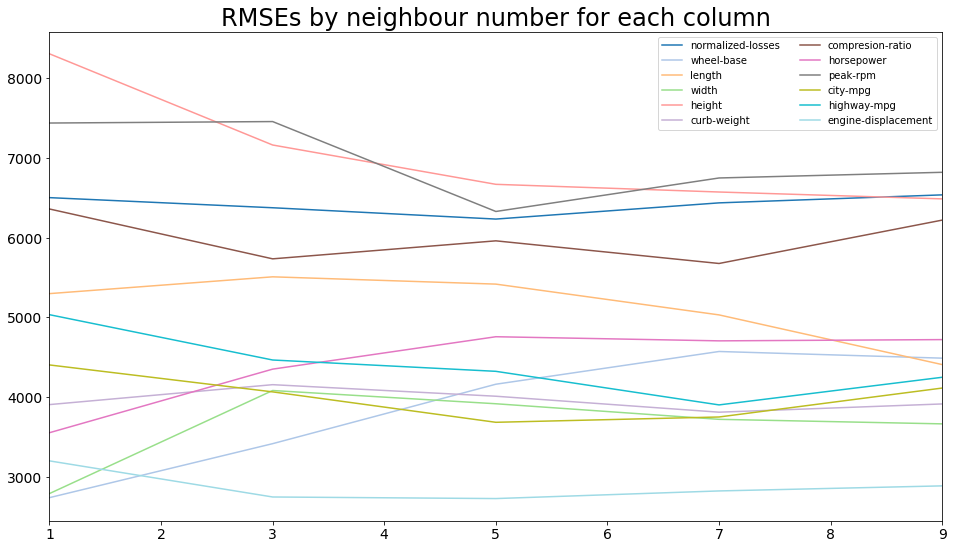

In [28]:
fig, ax = plt.subplots(figsize=(16,9))

#Colors
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, len(train_cols))]

for i, column in enumerate(col_diff_k_dict):
    x = col_diff_k_dict[column].keys()
    y = col_diff_k_dict[column].values()
    ax.plot(x, y, color=colors[i])
        
#Decorations
ax.set_title('RMSEs by neighbour number for each column', fontsize=24)
ax.set_xlim(1, 9)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(col_diff_k_dict.keys(), ncol=2)

Also we'll calculate mean RMSE value for each column.

In [21]:
col_diff_k_avg = {}

for column, k_dict in col_diff_k_dict.items():
    col_diff_k_avg[column] = np.mean(list(k_dict.values()))
    
col_diff_k_avg

col_k_dict_avg_sorted = {key: value for key, value in sorted(col_diff_k_avg.items(), key=lambda item: item[1])}
col_k_dict_avg_sorted

{'engine-displacement': 2878.5262681644335,
 'width': 3635.853430382477,
 'wheel-base': 3876.0590547101942,
 'curb-weight': 3960.1474873745997,
 'city-mpg': 4003.9502301932284,
 'highway-mpg': 4394.79315267596,
 'horsepower': 4417.726817969548,
 'length': 5131.896083301219,
 'compresion-ratio': 5988.485822833031,
 'normalized-losses': 6414.628999407328,
 'peak-rpm': 6955.5533336983935,
 'height': 7036.577149759573}

### Several columns

We used only one column at once before, now we'll add to our model ability to train and predict using any number of columns. But wiyhout any neigbour number variation.

Let's modify `knn_train_test_hp` function.

In [22]:
def knn_train_test_hp_multicol(train_cols, target_col, df):
    '''
    train_cols - column to train
    target_col - column to predict
    df - data set
    '''
    
    #Shuffling index
    np.random.seed(1)
    rand_df = df.reindex(np.random.permutation(df.index))
    
    #Splitting data set
    train_qty = int(df.shape[0] * 0.75) #Rows qty for training part
    
    train_df = rand_df.iloc[0:train_qty]
    test_df = rand_df.iloc[train_qty:]
    
    hyperparameters = [5] #hp values
    
    rmses_dict = {} # dict for RMSE from each hp
    
    #Instantiating model for each hp
    for hp in hyperparameters:
        knn = KNeighborsRegressor(hp)
        knn.fit(train_df[train_cols], train_df[[target_col]])
        predictions = knn.predict(test_df[train_cols])
    
        #Calculating RMSE
        rmse = mean_squared_error(test_df[target_col], predictions, squared=False)
        rmses_dict[hp] = rmse
        
    return rmses_dict

Now we'll use the best **2-5** columns from the first test for our new function. 

In [23]:
multicol_k_dict = {}

keys_list = list(col_k_dict_avg_sorted.keys()) #Keys from the previous test


for i in range(2,6):
    rmse = knn_train_test_hp_multicol(keys_list[:i], 'price', cars_model)
    multicol_k_dict[str(i) + ' best columns'] = rmse
    
multicol_k_dict

{'2 best columns': {5: 2600.5268154062665},
 '3 best columns': {5: 2849.0816686275957},
 '4 best columns': {5: 2395.1240166016373},
 '5 best columns': {5: 2533.890548110538}}

### Combined model

In this step we'll use both: hyperparameter variation and multicolumn model. Columns we'll take from the previous tests and k value variate from **1 to 25**.

Let's modify our function once again.

In [24]:
def knn_train_test_hp25_multicol(train_cols, target_col, df):
    '''
    train_cols - column to train
    target_col - column to predict
    df - data set
    '''
    
    #Shuffling index
    np.random.seed(1)
    rand_df = df.reindex(np.random.permutation(df.index))
    
    #Splitting data set
    train_qty = int(df.shape[0] * 0.75) #Rows qty for training part
    
    train_df = rand_df.iloc[0:train_qty]
    test_df = rand_df.iloc[train_qty:]
    
    hyperparameters = list(range(1,26)) #hp values
    
    rmses_dict = {} # dict for RMSE from each hp
    
    #Instantiating model for each hp
    for hp in hyperparameters:
        knn = KNeighborsRegressor(hp)
        knn.fit(train_df[train_cols], train_df[[target_col]])
        predictions = knn.predict(test_df[train_cols])
    
        #Calculating RMSE
        rmse = mean_squared_error(test_df[target_col], predictions, squared=False)
        rmses_dict[hp] = rmse
        
    return rmses_dict

Let's try new function.

In [25]:
multicol_diff_k_dict = {}

for i in range(2,6):
    rmses = knn_train_test_hp25_multicol(keys_list[:i], 'price', cars_model)
    multicol_diff_k_dict[str(i) + ' best columns'] = rmses
    
multicol_diff_k_dict

{'2 best columns': {1: 2529.973478896877,
  2: 2236.066425405008,
  3: 2331.469913725173,
  4: 2556.5601355563076,
  5: 2600.5268154062665,
  6: 2688.42670854374,
  7: 2704.7277226407555,
  8: 2825.602574985503,
  9: 2890.1888263483197,
  10: 2961.8412329521793,
  11: 2877.1212515849074,
  12: 2912.132667911513,
  13: 2949.625095080983,
  14: 3060.5283692623443,
  15: 3160.5197507671273,
  16: 3267.591846890395,
  17: 3368.706701998129,
  18: 3447.438366241539,
  19: 3499.8813739838606,
  20: 3580.1961889842914,
  21: 3663.654574951089,
  22: 3725.7149154842314,
  23: 3789.1833696906833,
  24: 3820.1937279822714,
  25: 3866.996549476447},
 '3 best columns': {1: 2396.1321733487207,
  2: 2372.5778928926943,
  3: 2564.8290030360336,
  4: 2807.1150651461703,
  5: 2849.0816686275957,
  6: 2814.303197502495,
  7: 2736.940747451801,
  8: 2805.2268228932758,
  9: 2895.1002309300866,
  10: 2962.3903746408414,
  11: 3056.1092564554433,
  12: 3023.134150498744,
  13: 3084.559499913151,
  14: 3214

We definitely need need a plot so build one.

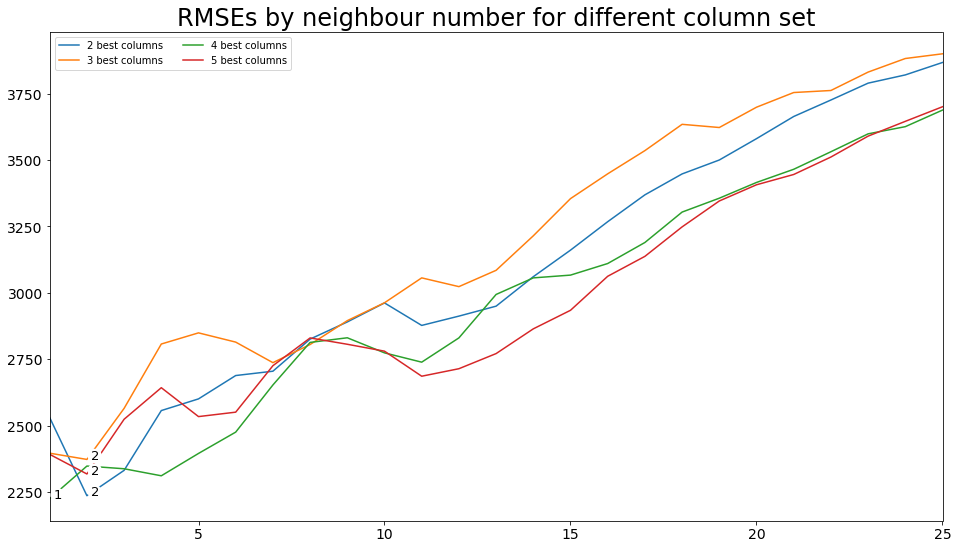

In [59]:
fig, ax = plt.subplots(figsize=(16,9))

for columns in multicol_diff_k_dict:
    x = multicol_diff_k_dict[columns].keys()
    y = multicol_diff_k_dict[columns].values()
    ax.plot(x, y)

    #Mark k value for min RMSE
    ax.text(min(multicol_diff_k_dict[columns], key=multicol_diff_k_dict[columns].get) + 0.1,
            min(multicol_diff_k_dict[columns].values()),
            s=str(min(multicol_diff_k_dict[columns], key=multicol_diff_k_dict[columns].get)),
            horizontalalignment='left',
            fontsize=13,
            bbox={'facecolor': 'white', 'alpha': 1, 'edgecolor':'none',
                  'boxstyle': 'circle', 'pad': 0.05
                 },
           )
    
            
   #str(min(multicol_diff_k_dict[columns], key=multicol_diff_k_dict[columns].get))     
#Decorations
ax.set_title('RMSEs by neighbour number for different column set', fontsize=24)
ax.set_xlim(1, 25)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(multicol_diff_k_dict.keys(), ncol=2)

Now we can tell the best k value for all column set:
* **k=1** for `engine-displacement`+`width`+`wheel-base`+`curb-weight`
* **k=2** for:
    * `engine-displacement`+`width`+`wheel-base`+`curb-weight`+`city-mpg`
    * `engine-displacement`+`width`+`wheel-base`
    *  `engine-displacement`+`width`